# Regression Task

### loading data

In [121]:
#%% reading the data
# select the data number
# 0- bitrate
# 1 - stream quality
SDn = 1 # select numbe
num_selected = 3
#
DSs = ['bitrate_prediction','stream_quality_data']
targets_names = ['target','stream_quality']
target_name = targets_names[SDn]

# loading training and testing
import os
init_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "\\data\\"
import pandas as pd
train_data = pd.read_csv(init_dir + DSs[SDn] + '\\train_data.csv', low_memory=False)
test_data = pd.read_csv(init_dir + DSs[SDn] + '\\test_data.csv', low_memory=False)

# split targets and features
if SDn==1:
    train_targets = train_data[target_name]
    test_targets = test_data[target_name]
    train_data.drop(target_name, axis=1, inplace=True)
    test_data.drop(target_name, axis=1, inplace=True)
else:
    train_targets = train_data[target_name]
    test_targets = test_data[target_name]
    train_data.drop(target_name, axis=1, inplace=True)
    test_data.drop(target_name, axis=1, inplace=True)
# generating validation data
from sklearn.model_selection import train_test_split
test_data, val_data, test_targets, val_targets = train_test_split(test_data, test_targets,test_size=0.5)

## data profiling and save the profiles in docs folder

In [122]:
from pandas_profiling import ProfileReport

report = ProfileReport(train_data)
#report.to_file(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "\\docs\\"  + DSs[SDn] + '.html')

## preprocessing

In [123]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scaler_robust(data):
    scaler = RobustScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    return scaled_data


def scaler_standard(data):
    scaler = StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    return scaled_data
    
    
def preprocesser(data,type_):
    if type_==0:
        preprocessed_data = scaler_robust(data)
    else:
        cleanup_nums = {"auto_bitrate_state":     {"off": 0, "full": 1,"partial":0.5},
                "auto_fec_state": {"off": 0, "partial": 0.5}}
        preprocessed_data = data.replace(cleanup_nums)
        preprocessed_data = scaler_standard(preprocessed_data)
    preprocessed_data = pd.DataFrame(preprocessed_data, index=data.index, columns=data.columns)
    return preprocessed_data

In [124]:
train_data = preprocesser(train_data,SDn)
test_data = preprocesser(test_data,SDn)
val_data = preprocesser(val_data,SDn)

## Feature Selection

In [125]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
def feature_selector(data,targets,type_,num_selected):
    if type_==0:
        bestfeatures = SelectKBest(score_func=chi2, k=num_selected)
    else:
        bestfeatures = SelectKBest(score_func=f_regression, k=num_selected)
    bestfeatures.fit(data.astype('int'),targets.astype('int'))
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    #concatenate the two dataframes
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feats','Score']
    #print 10 best features
    print(featureScores.nlargest(9,'Score').plot(kind='barh'))
    #plot graph of feature importances 
    plt.show()
    selected_feats = bestfeatures.get_feature_names_out(input_features=None)
    return selected_feats

AxesSubplot(0.125,0.11;0.775x0.77)


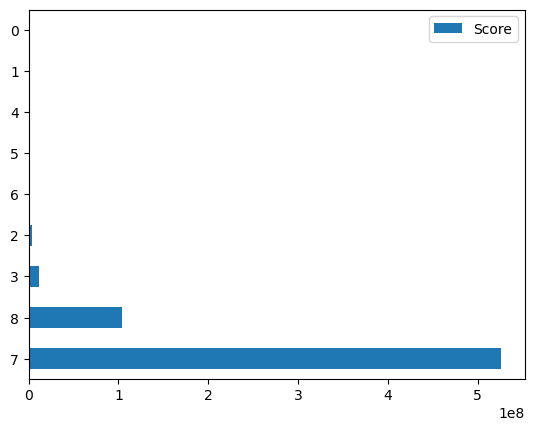

In [126]:
tmp = train_data.copy()
tmp["target"] = train_targets
sample = tmp.sample(n = int(1*len(tmp)))
sample_targets = sample["target"]
sample.drop("target", axis=1, inplace=True)
best_feats = feature_selector(sample,sample_targets,SDn,num_selected)
train_data = train_data[best_feats]
test_data = test_data[best_feats]
val_data = val_data[best_feats]

## data visualization

In [127]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def projector(data):
    dim_reducer = PCA(n_components=2)
    data_reduced = dim_reducer.fit_transform(data)
    return data_reduced
    
def visualizer(data):
    data_reduced = projector(data)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.')
    plt.xlabel('Prinicipal Comp1')
    plt.ylabel('Prinicipal Comp2')
    plt.show()

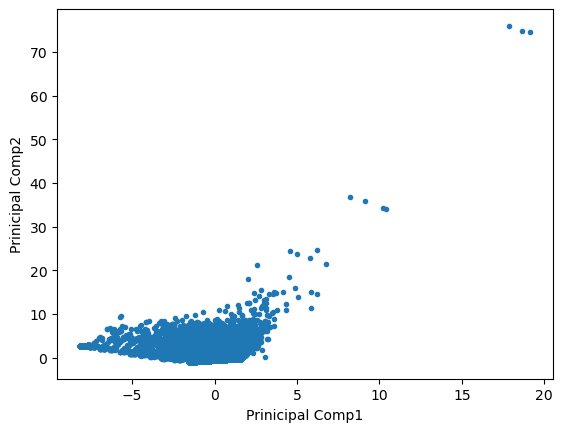

In [128]:
visualizer(train_data)

## regression models

In [129]:
def fit_LR(train_data,train_targets):
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(train_data, train_targets)
    return regressor

# polynomial linear regression with Ridge regularization
def fit_PLR(train_data,train_targets,val_data,val_targets):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PolynomialFeatures #to convert the original features into their higher order terms 
    from sklearn.linear_model import Ridge
    from sklearn.metrics import mean_squared_error

    import numpy as np
    alphas = [0.01,0.1,1]
    losses = []
    for i in range(len(alphas)):

        polynomial_features = PolynomialFeatures(degree=3)
        linear_regression = Ridge(alpha =i )
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
        pipeline.fit(train_data, train_targets)

    # Evaluate the models using crossvalidation
        mse = mean_squared_error(pipeline.predict(val_data),val_targets)
        losses.append(mse)
    ind = np.argmin(losses)
    print(ind)
    best_alpha = alphas[ind]
    linear_regression = Ridge(alpha =best_alpha )
    pipeline.fit(train_data, train_targets)
    return pipeline

# Neural Network
def fit_NN(train_data,train_targets):
    from sklearn.neural_network import MLPRegressor
    regr = MLPRegressor( max_iter=100,hidden_layer_sizes=(20,),alpha = 1)
    regr.fit(train_data, train_targets)   
    return regr

## classification models

In [130]:
def Log_reg_L2_fit(train_data,test_data):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0).fit(train_data, test_data)
    return clf

def Log_reg_fit(train_data,test_data):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0,penalty='none').fit(train_data, test_data)
    return clf

## Outliers Detection For Classification Dataset

In [131]:
def remove_outliers(train_data,train_targets):
    from scipy import stats
    import numpy as np

    # Calculate the z-scores
    z_scores = stats.zscore(train_data)
    abs_z_scores = np.abs(z_scores)
    # Select data points with a z-scores above or below 3
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    train_wo_outliers = train_data[filtered_entries]
    train_targets = train_targets[filtered_entries]
    return train_wo_outliers,train_targets

In [132]:
if SDn==1:
    train_data,train_targets = remove_outliers(train_data,train_targets)

## Data Balancing For Classification Dataset

In [133]:
import numpy as np
import pandas as pd

def data_balancer(train_data,train_targets):
    minor_class_recs = train_targets==1
    train_minor =  train_data[minor_class_recs]
    mul_times = 2 # how much will the class be duplicated
    records = train_minor.to_numpy()
    new_recs = []
    for i in range(int(mul_times*records.shape[0])):
        nnn = int(np.random.uniform(low=0,high=records.shape[0]))
        tmp_rec = records[nnn,:] 
        new_recs.append(tmp_rec)
    new_recs = np.array(new_recs)
    old_recs = records
    new_train_minor_data = np.concatenate((old_recs,new_recs),axis=0)
    major_class_recs = train_targets==0
    train_major =  train_data[major_class_recs]
    train_major_np = train_major.to_numpy()
    new_train_data_np = np.concatenate((train_major_np,new_train_minor_data),axis=0)
    new_train_data = pd.DataFrame(new_train_data_np, columns=train_data.columns)
    new_targets_np = np.concatenate((np.zeros((train_major_np.shape[0],1)),np.ones((new_train_minor_data.shape[0],1))),axis = 0)
    new_train_data["targets"] = (new_targets_np. astype(int))
    from sklearn.utils import shuffle
    new_data = shuffle(new_train_data)
    new_train_targets = new_data["targets"]
    new_data.drop('targets', axis=1, inplace=True)
    return new_data,new_train_targets

In [134]:
if SDn==1:
    train_data_balanced,train_targets_balanced = data_balancer(train_data,train_targets)

## Models Fitting and Testing

In [138]:
if SDn==0:
    model = fit_LR(train_data,train_targets)
    LR_pred_test_targets = model.predict(test_data)
    LR_pred_train_targets = model.predict(train_data)
    # polynomial regression
    model = fit_PLR(train_data,train_targets,val_data,val_targets)
    PLR_pred_test_targets = model.predict(test_data)
    PLR_pred_train_targets = model.predict(train_data)
    # NN
    model = fit_NN(train_data,train_targets)
    NN_pred_test_targets = model.predict(test_data)
    NN_pred_train_targets = model.predict(train_data)
    # printing
    from sklearn import metrics
    import numpy as np
    
    print('Training Mean Absolute Error For LR:', metrics.mean_absolute_error(train_targets, LR_pred_train_targets))
    print('Training Mean Absolute Error For PLR:', metrics.mean_absolute_error(train_targets, PLR_pred_train_targets))
    print('Training Mean Absolute Error For NN:', metrics.mean_absolute_error(train_targets, NN_pred_train_targets))
    
    print('Testing Mean Absolute Error For LR:', metrics.mean_absolute_error(test_targets, LR_pred_test_targets))
    print('Testing Mean Absolute Error For PLR:', metrics.mean_absolute_error(test_targets, PLR_pred_test_targets))
    print('Testing Mean Absolute Error For NN:', metrics.mean_absolute_error(test_targets, NN_pred_test_targets))
    
    print('Training Mean Squared Error For LR:', metrics.mean_squared_error(train_targets, LR_pred_train_targets))
    print('Training Mean Squared Error For PLR:', metrics.mean_squared_error(train_targets, PLR_pred_train_targets))
    print('Training Mean Squared Error For NN:', metrics.mean_squared_error(train_targets, NN_pred_train_targets))
    
    print('Testing Mean Squared Error For LR:', metrics.mean_squared_error(test_targets, LR_pred_test_targets))
    print('Testing Mean Squared Error For PLR:', metrics.mean_squared_error(test_targets, PLR_pred_test_targets))
    print('Testing Mean Squared Error For NN:', metrics.mean_squared_error(test_targets, NN_pred_test_targets))

    print('Training Root Mean Squared Error  For LR:', np.sqrt(metrics.mean_squared_error(train_targets, LR_pred_train_targets)))
    print('Training Root Mean Squared Error For PLR:', np.sqrt(metrics.mean_squared_error(train_targets, PLR_pred_train_targets)))
    print('Training Root Mean Squared Error For NN:', np.sqrt(metrics.mean_squared_error(train_targets, NN_pred_train_targets)))
    
    print('Testing Root Mean Squared Error  For LR:', np.sqrt(metrics.mean_squared_error(test_targets, LR_pred_test_targets)))
    print('Testing Root Mean Squared Error For PLR:', np.sqrt(metrics.mean_squared_error(test_targets, PLR_pred_test_targets)))
    print('Testing Root Mean Squared Error For NN:', np.sqrt(metrics.mean_squared_error(test_targets, NN_pred_test_targets)))
    
    print('Training R2  For LR:', metrics.r2_score(train_targets, LR_pred_train_targets))
    print('Training R2  For PLR:', metrics.r2_score(train_targets, PLR_pred_train_targets))
    print('Training R2  For NN:', metrics.r2_score(train_targets, NN_pred_train_targets))
    
    print('Testing R2  For LR:', metrics.r2_score(test_targets, LR_pred_test_targets))
    print('Testing R2  For PLR:', metrics.r2_score(test_targets, PLR_pred_test_targets))
    print('Testing R2  For NN:', metrics.r2_score(test_targets, NN_pred_test_targets))

else:
    from sklearn import metrics
    
    model = Log_reg_fit(train_data,train_targets)
    Log_reg_pred_test_targets = model.predict(test_data)
    Log_reg_pred_train_targets =  model.predict(train_data)
    model = Log_reg_fit(train_data_balanced,train_targets_balanced)
    Log_reg_pred_test_targets_balanc = model.predict(test_data)
    Log_reg_pred_train_targets_balanc = model.predict(train_data)
    model = Log_reg_L2_fit(train_data,train_targets)
    Log_reg_L2_pred_test_targets = model.predict(test_data)
    Log_reg_L2_pred_train_targets = model.predict(train_data)
    model = Log_reg_L2_fit(train_data_balanced,train_targets_balanced)
    Log_reg_L2_pred_test_targets_balanc = model.predict(test_data)
    Log_reg_L2_pred_train_targets_balanc = model.predict(train_data)
    # classif_models.run_classif_models()
    
    precision_Log_train = metrics.precision_score(train_targets,Log_reg_pred_train_targets)
    print('Training Acc for Logistic regression: ',metrics.accuracy_score(train_targets,Log_reg_pred_train_targets))
    print('Training Precision for Logistic regression: ',precision_Log_train)
    recall_Log_train = metrics.recall_score(train_targets,Log_reg_pred_train_targets)
    print('Training Recall for Logistic regression: ',recall_Log_train)
    print('Training F1 for Logistic regression: ',2 * (precision_Log_train * recall_Log_train) / (precision_Log_train + recall_Log_train))
    print('Training F1-weighted for Logistic regression: ',metrics.f1_score(train_targets, Log_reg_pred_train_targets, average='weighted'))
    
    
    precision_Log = metrics.precision_score(test_targets,Log_reg_pred_test_targets)
    print('Testing Acc for Logistic regression: ',metrics.accuracy_score(test_targets,Log_reg_pred_test_targets))
    print('Testing Precision for Logistic regression: ',precision_Log)
    recall_Log = metrics.recall_score(test_targets,Log_reg_pred_test_targets)
    print('Testing Recall for Logistic regression: ',recall_Log)
    print('Testing F1 for Logistic regression: ',2 * (precision_Log * recall_Log) / (precision_Log + recall_Log))
    print('Testing F1-weighted for Logistic regression: ',metrics.f1_score(test_targets, Log_reg_pred_test_targets, average='weighted'))
    
    precision_Log_L2_train = metrics.precision_score(train_targets,Log_reg_L2_pred_train_targets)
    print('Training Acc for Logistic regression with L2: ',metrics.accuracy_score(train_targets,Log_reg_L2_pred_train_targets))
    print('Training Precision for Logistic regression with L2: ',precision_Log_L2_train)
    recall_Log_L2_train = metrics.recall_score(train_targets,Log_reg_L2_pred_train_targets)
    print('Training Recall for Logistic regression with L2: ',recall_Log_L2_train)
    print('Training F1 for Logistic regression with L2: ',2 * (precision_Log_L2_train * recall_Log_L2_train) / (precision_Log_L2_train + recall_Log_L2_train))
    print('Training F1-weighted for Logistic regression with L2: ',metrics.f1_score(train_targets, Log_reg_L2_pred_train_targets, average='weighted'))
    
    precision_Log_L2 = metrics.precision_score(test_targets,Log_reg_L2_pred_test_targets)
    print('Testing Acc for Logistic regression with L2: ',metrics.accuracy_score(test_targets,Log_reg_L2_pred_test_targets))
    print('Testing Precision for Logistic regression with L2: ',precision_Log_L2)
    recall_Log_L2 = metrics.recall_score(test_targets,Log_reg_L2_pred_test_targets)
    print('Testing Recall for Logistic regression with L2: ',recall_Log_L2)
    print('Testing F1 for Logistic regression with L2: ',2 * (precision_Log_L2 * recall_Log_L2) / (precision_Log_L2 + recall_Log_L2))
    print('Testing F1-weighted for Logistic regression with L2: ',metrics.f1_score(test_targets, Log_reg_L2_pred_test_targets, average='weighted'))

    precision_Log_balanc_train = metrics.precision_score(train_targets,Log_reg_pred_train_targets_balanc)
    print('Training Acc for Logistic regression Balanced Data: ',metrics.accuracy_score(train_targets,Log_reg_pred_train_targets_balanc))
    print('Training Precision for Logistic regression Balanced Data: ',precision_Log_balanc_train)
    recall_Log_balanc_train = metrics.recall_score(train_targets,Log_reg_pred_train_targets_balanc)
    print('Training Recall for Logistic regression Balanced Data: ',recall_Log_balanc_train)
    print('Training F1 for Logistic regression Balanced Data: ',2 * (precision_Log_balanc_train * recall_Log_balanc_train) / (precision_Log_balanc_train + recall_Log_balanc_train))
    print('Training F1-weighted for Logistic regression Balanced Data: ',metrics.f1_score(train_targets, Log_reg_pred_train_targets_balanc, average='weighted'))

    precision_Log_balanc = metrics.precision_score(test_targets,Log_reg_pred_test_targets_balanc)
    print('Testing Acc for Logistic regression Balanced Data: ',metrics.accuracy_score(test_targets,Log_reg_pred_test_targets_balanc))
    print('Testing Precision for Logistic regression Balanced Data: ',precision_Log_balanc)
    recall_Log_balanc = metrics.recall_score(test_targets,Log_reg_pred_test_targets_balanc)
    print('Testing Recall for Logistic regression Balanced Data: ',recall_Log_balanc)
    print('Testing F1 for Logistic regression Balanced Data: ',2 * (precision_Log_balanc * recall_Log_balanc) / (precision_Log_balanc + recall_Log_balanc))
    print('Testing F1-weighted for Logistic regression Balanced Data: ',metrics.f1_score(test_targets, Log_reg_pred_test_targets_balanc, average='weighted'))

    
    precision_Log_L2_balanc_train = metrics.precision_score(train_targets,Log_reg_L2_pred_train_targets_balanc)
    print('Training Acc for Logistic regression with L2 Balanced Data: ',metrics.accuracy_score(train_targets,Log_reg_L2_pred_train_targets_balanc))
    print('Training Precision for Logistic regression with L2 Balanced Data: ',precision_Log_L2_balanc_train)
    recall_Log_L2_balanc_train = metrics.recall_score(train_targets,Log_reg_L2_pred_train_targets_balanc)
    print('Training Recall for Logistic regression with L2 Balanced Data: ',recall_Log_L2_balanc_train)
    print('Training F1 for Logistic regression with L2 Balanced Data: ',2 * (precision_Log_L2_balanc_train * recall_Log_L2_balanc_train) / (precision_Log_L2_balanc_train + recall_Log_L2_balanc_train))
    print('Training F1-weighted for Logistic regression with L2 Balanced Data: ',metrics.f1_score(train_targets, Log_reg_L2_pred_train_targets_balanc, average='weighted'))
    
    precision_Log_L2_balanc = metrics.precision_score(test_targets,Log_reg_L2_pred_test_targets_balanc)
    print('Testing Acc for Logistic regression with L2 Balanced Data: ',metrics.accuracy_score(test_targets,Log_reg_L2_pred_test_targets_balanc))
    print('Testing Precision for Logistic regression with L2 Balanced Data: ',precision_Log_L2_balanc)
    recall_Log_L2_balanc = metrics.recall_score(test_targets,Log_reg_L2_pred_test_targets_balanc)
    print('Testing Recall for Logistic regression with L2 Balanced Data: ',recall_Log_L2_balanc)
    print('Testing F1 for Logistic regression with L2 Balanced Data: ',2 * (precision_Log_L2_balanc * recall_Log_L2_balanc) / (precision_Log_L2_balanc + recall_Log_L2_balanc))
    print('Testing F1-weighted for Logistic regression with L2 Balanced Data: ',metrics.f1_score(test_targets, Log_reg_L2_pred_test_targets_balanc, average='weighted'))

   

Training Acc for Logistic regression:  0.9499565728299187
Training Precision for Logistic regression:  0.6012759170653907
Training Recall for Logistic regression:  0.03799637169925418
Training F1 for Logistic regression:  0.07147596928618827
Training F1-weighted for Logistic regression:  0.9285198665916139
Testing Acc for Logistic regression:  0.9293338150051725
Testing Precision for Logistic regression:  0.4374443851219078
Testing Recall for Logistic regression:  0.3109817813765182
Testing F1 for Logistic regression:  0.36352880278044813
Testing F1-weighted for Logistic regression:  0.9237144487477955
Training Acc for Logistic regression with L2:  0.9499565728299187
Training Precision for Logistic regression with L2:  0.6012759170653907
Training Recall for Logistic regression with L2:  0.03799637169925418
Training F1 for Logistic regression with L2:  0.07147596928618827
Training F1-weighted for Logistic regression with L2:  0.9285198665916139
Testing Acc for Logistic regression with L

In [161]:
def coloredBar(bars,height,titl):
    colors = [[0.17, 0.78, 0.88],[0.6, 0.7, 0.84],[0.82, 0.6, 0.84],[0.88, 0.26, 0.58],
              [0.72,0.2,0.34],[0.93,0.63,0.2],[0.93,0.87,0.2],[0.71,0.93,0.2],[0.3,0.51,0.05],
              [0.11,0.23,0.81],[0.67,0.11,0.81]]
    x_pos = np.arange(len(bars))
    plt.figure()
    for x in x_pos:
        plt.bar(x, height[x], color=colors[x], label = bars[x])
        plt.legend(loc='best')
    plt.title(titl)
    plt.show()

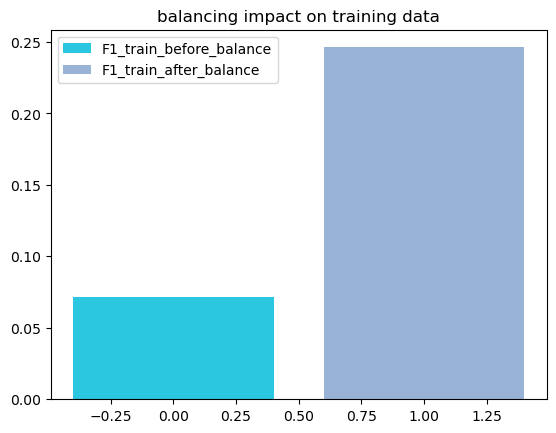

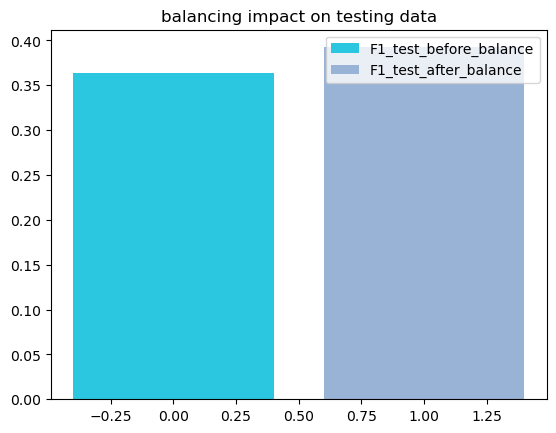

In [162]:
bars = ['F1_train_before_balance', 'F1_train_after_balance']
F1_train_befor_balancing = 2 * (precision_Log_train * recall_Log_train) / (precision_Log_train + recall_Log_train)
F1_train_after_balancing = 2 * (precision_Log_balanc_train * recall_Log_balanc_train) / (precision_Log_balanc_train + recall_Log_balanc_train)
F1_test_befor_balancing = 2 * (precision_Log * recall_Log) / (precision_Log + recall_Log)
F1_test_after_balancing = 2 * (precision_Log_balanc * recall_Log_balanc) / (precision_Log_balanc + recall_Log_balanc)
coloredBar(bars,[F1_train_befor_balancing,F1_train_after_balancing],'balancing impact on training data')
bars = ['F1_test_before_balance', 'F1_test_after_balance']
coloredBar(bars,[F1_test_befor_balancing,F1_test_after_balancing],'balancing impact on testing data')